In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.exposure
from scipy.ndimage import gaussian_filter

In [2]:
def log_entropy(image, sigma_smooth=2.25):
  N = 256
  n_hist = np.zeros(N, dtype=float)

  rescaled_image = (N - 1) * (image / image.max())
  li = (N - 1) * np.log2(1 + rescaled_image) / np.log2(N)
  li_floor = np.floor(li).astype(int)
  li_ceil = np.ceil(li).astype(int)

  np.add.at(n_hist, li_floor, 1 + li_floor - li)
  np.add.at(n_hist, li_ceil, li_ceil - li)

  n_hist_smooth = gaussian_filter(n_hist, sigma_smooth)

  pk = n_hist_smooth / np.sum(n_hist_smooth)
  log_pk = np.where(pk != 0, np.log2(pk), 0)

  return - np.sum(pk * log_pk)

In [3]:
def compute_center_of_mass(image):
  (sum, i_sum, j_sum) = (0, 0, 0)

  for j in range(image.shape[0]):
    for i in range(image.shape[1]):
      sum += image[j, i]

      i_sum += (i + 1) * image[j, i]
      j_sum += (j + 1) * image[j, i]

  return (i_sum / sum, j_sum / sum)

In [4]:
def compute_r_matrix(image):
  (i_mid, j_mid) = compute_center_of_mass(image)

  res = np.empty_like(image, dtype=float)

  d = np.sqrt(i_mid**2 + j_mid**2)

  for j in range(image.shape[0]):
    for i in range(image.shape[1]):
      res[j, i] = np.sqrt((i - i_mid)**2 + (j - j_mid)**2) / d

  return res

In [5]:
def g(r, a, b, c):
  return 1 + a * r**2 + b * r**4 + c * r**6

In [6]:
def verify_constraints(a, b, c):
  if a > 0 and b == 0 and c == 0:
      return True
  if a >= 0 and b > 0 and c == 0:
      return True
  if c == 0 and b < 0 and -a <= 2 * b:
      return True
  if c > 0 and b**2 < 3 * a * c:
      return True
  if c > 0 and b**2 == 3 * a * c and b >= 0:
      return True
  if c > 0 and b**2 == 3 * a * c and -b >= 3 * c:
      return True
  q_p = (-2 * b + np.sqrt(4 * b**2 - 12 * a * c)) / (6 * c)
  if c > 0 and b**2 > 3 * a * c and q_p <= 0:
      return True
  q_d = (-2 * b - np.sqrt(4 * b**2 - 12 * a * c)) / (6 * c)
  if c > 0 and b**2 > 3 * a * c and q_d >= 1:
      return True
  if c < 0 and b**2 > 3 * a * c and q_p >= 1 and q_d <= 0:
      return True

  return False

In [7]:
def rgb_to_luminance(image):
  return 0.2126 * image[...,0] + 0.7152 * image[...,1] + 0.0722 * image[...,2]

In [8]:
def correct_vignetting(image):
  gray_image = rgb_to_luminance(image)

  (a, b, c) = (0.0, 0.0, 0.0)
  delta = 8.0
  h_min = log_entropy(gray_image)
  r = compute_r_matrix(gray_image)

  while delta > 1 / 256:
    v_arr = np.array([(a + delta, b, c), (a - delta, b, c),
                      (a, b + delta, c), (a, b - delta, c),
                      (a, b, c + delta), (a, b, c - delta)])

    for v in v_arr:
      if verify_constraints(*v):
        h_tmp = log_entropy(gray_image * g(r, *v))
        if h_tmp < h_min:
          h_min = h_tmp
          (a, b, c) = v
          delta = 16.0

    delta /= 2.0

  print(f"Coefficients: ({a}, {b}, {c}), Minimal entropy: {h_min}")

  plt.imshow(g(r, a, b, c))
  plt.show()

  res = image * np.stack(3 * [g(r, a, b, c)], axis=2)

  return skimage.exposure.equalize_hist(res)

In [9]:
image = plt.imread('vignetting-1.jpeg')

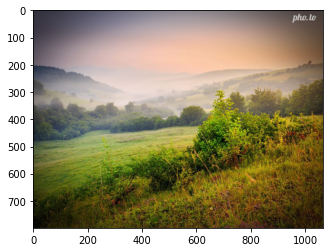

In [10]:
plt.imshow(image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Coefficients: (0.4921875, 0.0, 2.375), Minimal entropy: 6.063647634920599


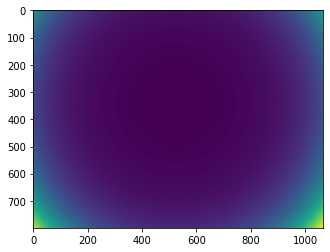

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [11]:
corrected_image = correct_vignetting(image)

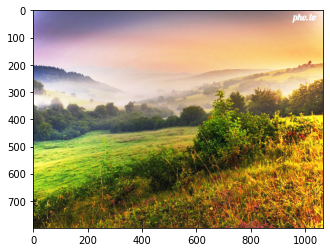

In [12]:
plt.imshow(corrected_image)

In [13]:
image = plt.imread('lena.jpg')

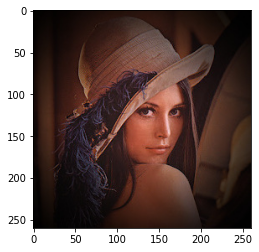

In [14]:
plt.imshow(image)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


Coefficients: (0.0625, 11.0, 10.125), Minimal entropy: 6.577058597901512


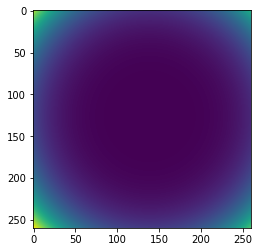

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [15]:
corrected_image = correct_vignetting(image)

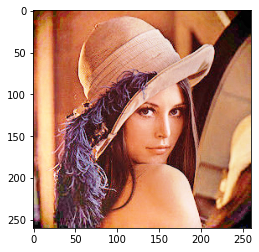

In [16]:
plt.imshow(corrected_image)